# TCN模型训练与评估

本notebook实现了基于时序卷积网络(TCN)的农作物制图模型训练、评估和推理流程。

## 1. 环境设置与导入

In [1]:
import sys
import os
sys.path.append('..')

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 导入自定义模块
from TCN.model import create_tcn_model
from TCN.dataset import prepare_data, save_data_info
from TCN.utils import (
    save_checkpoint, 
    calculate_metrics,
    plot_training_history,
    plot_confusion_matrix,
    plot_class_performance
)
from TCN.train import FocalLoss

# 设置matplotlib中文显示
plt.rcParams['font.sans-serif'] = ['PingFang SC', 'SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.7.1
CUDA available: False


## 2. 模式选择与配置参数

本notebook支持两种运行模式：

### 🔧 测试模式 (test)
- **用途**: 在本地Mac快速验证代码正确性
- **特点**: 
  - 小批次大小 (batch_size=4)
  - 少训练轮数 (epochs=5)
  - 轻量化模型结构
  - 快速早停 (patience=2)
  - 使用MPS设备优化
- **适用场景**: 调试代码、验证功能、本地开发

### 🚀 训练模式 (train) 
- **用途**: 在云GPU进行完整的模型训练
- **特点**:
  - 大批次大小 (batch_size=16)
  - 完整训练轮数 (epochs=100)
  - 完整模型结构
  - 标准早停 (patience=10)
  - 优化并行处理
- **适用场景**: 正式训练、获得最佳性能、云端部署

**使用方法**: 在配置cell中修改 `MODE = 'test'` 或 `MODE = 'train'`

In [2]:
# 模式选择：'test' 或 'train'
# test: 本地Mac测试，小数据集，少轮数
# train: 云GPU训练，完整数据集，完整轮数
MODE = 'test'  # 切换为 'train' 进行完整训练

# 训练配置

# 首先，确定可用的最佳设备（GPU > MPS > CPU）
if torch.cuda.is_available():
    device = 'cuda'
# 检查macOS的MPS后端是否可用
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

# 根据模式设置基础配置
if MODE == 'test':
    # 测试模式配置 - 用于本地验证代码正确性
    base_config = {
        # 数据参数 - 使用较小的参数快速测试
        'patch_size': 32,
        'stride': 16,
        'test_size': 0.2,
        'val_size': 0.1,
        'batch_size': 4,  # 小批次
        'num_workers': 1,  # Mac上使用较少workers
        
        # 模型参数 - 使用轻量化模型
        'tcn_channels': [32, 64],  # 简化网络结构
        'kernel_size': 3,
        'dropout': 0.2,
        
        # 训练参数 - 少轮数快速验证
        'epochs': 5,  # 仅5轮测试
        'learning_rate': 1e-3,
        'weight_decay': 1e-4,
        'use_focal_loss': True,
    }
    print("🔧 Test Mode - 本地测试配置（快速验证代码）")
    
elif MODE == 'train':
    # 训练模式配置 - 用于云GPU完整训练
    base_config = {
        # 数据参数 - 完整训练配置
        'patch_size': 64,
        'stride': 32,
        'test_size': 0.2,
        'val_size': 0.1,
        'batch_size': 16,  # 大批次，适合GPU
        'num_workers': 8,  # 云GPU可以使用更多workers
        
        # 模型参数 - 完整模型
        'tcn_channels': [64, 128, 256],  # 完整网络结构
        'kernel_size': 3,
        'dropout': 0.2,
        
        # 训练参数 - 完整训练
        'epochs': 100,  # 完整轮数
        'learning_rate': 1e-3,
        'weight_decay': 1e-4,
        'use_focal_loss': True,
    }
    print("🚀 Train Mode - 云GPU训练配置（完整训练）")

# 合并完整配置
config = {
    **base_config,
    # 通用参数
    'data_path': '../dataset',
    'input_channels': 8,
    'temporal_steps': 28,
    'save_dir': './checkpoints',
    'device': device,
    'mode': MODE
}

print(f"\nCurrent configuration (Mode: {MODE.upper()}):")
print("="*50)
for key, value in config.items():
    print(f"  {key}: {value}")

print(f"\nUsing device: {device}")
if MODE == 'test':
    print("⚠️  测试模式：仅用于验证代码正确性，不代表最终训练效果")
elif MODE == 'train':
    print("✅ 训练模式：完整训练配置，适合云GPU环境")

# 创建保存目录
mode_save_dir = f"{config['save_dir']}_{MODE}"
config['save_dir'] = mode_save_dir
Path(config['save_dir']).mkdir(parents=True, exist_ok=True)
print(f"保存目录: {mode_save_dir}")

🔧 Test Mode - 本地测试配置（快速验证代码）

Current configuration (Mode: TEST):
  patch_size: 32
  stride: 16
  test_size: 0.2
  val_size: 0.1
  batch_size: 4
  num_workers: 1
  tcn_channels: [32, 64]
  kernel_size: 3
  dropout: 0.2
  epochs: 5
  learning_rate: 0.001
  weight_decay: 0.0001
  use_focal_loss: True
  data_path: ../dataset
  input_channels: 8
  temporal_steps: 28
  save_dir: ./checkpoints
  device: mps
  mode: test

Using device: mps
⚠️  测试模式：仅用于验证代码正确性，不代表最终训练效果
保存目录: ./checkpoints_test


## 3. 数据加载与预处理

In [3]:
# 准备数据
print("Preparing data loaders...")
train_loader, val_loader, test_loader, data_info = prepare_data(
    data_path=config['data_path'],
    patch_size=config['patch_size'],
    stride=config['stride'],
    test_size=config['test_size'],
    val_size=config['val_size'],
    batch_size=config['batch_size'],
    num_workers=config['num_workers']
)

# 保存数据信息
save_data_info(data_info, f"{config['save_dir']}/data_info.pkl")

print(f"Number of classes: {data_info['num_classes']}")
print(f"Class names: {data_info['class_names']}")
print(f"Train samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")
print(f"Class weights: {data_info['class_weights']}")

Preparing data loaders...
Original data shape - X: (326, 1025, 28, 8), Y: (326, 1025)
Dataset split - Train: 837, Val: 120, Test: 240
Data info saved to ./checkpoints_test/data_info.pkl
Number of classes: 8
Class names: {0: 'Corn', 1: 'Wheat', 2: 'Sunflower', 3: 'Pumpkin', 4: 'Artificial_Surface', 5: 'Water', 6: 'Road', 7: 'Other'}
Train samples: 837
Validation samples: 120
Test samples: 240
Class weights: tensor([0.2270, 6.4003, 0.6761, 4.3405, 5.5721, 4.4758, 1.7092, 1.3487])


## 4. 创建模型

In [4]:
# 创建模型
device = torch.device(config['device'])
print(f"Using device: {device}")

model = create_tcn_model(
    input_channels=config['input_channels'],
    temporal_steps=config['temporal_steps'],
    num_classes=data_info['num_classes'],
    tcn_channels=config['tcn_channels'],
    kernel_size=config['kernel_size'],
    dropout=config['dropout']
).to(device)

# 打印模型信息
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model created successfully!")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# 测试模型前向传播
dummy_input = torch.randn(2, 64, 64, 28, 8).to(device)
with torch.no_grad():
    output = model(dummy_input)
print(f"Test input shape: {dummy_input.shape}")
print(f"Test output shape: {output.shape}")

Using device: mps
Model created successfully!
Total parameters: 34,216
Trainable parameters: 34,216
Test input shape: torch.Size([2, 64, 64, 28, 8])
Test output shape: torch.Size([2, 64, 64, 8])


## 5. 设置损失函数和优化器

In [5]:
# 损失函数
if config['use_focal_loss']:
    criterion = FocalLoss(alpha=data_info['class_weights'].to(device), gamma=2.0)
    print("Using Focal Loss")
else:
    criterion = nn.CrossEntropyLoss(weight=data_info['class_weights'].to(device))
    print("Using Cross Entropy Loss")

# 优化器
optimizer = optim.AdamW(
    model.parameters(),
    lr=config['learning_rate'],
    weight_decay=config['weight_decay']
)

# 学习率调度器
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,
    T_mult=2
)

print(f"Optimizer: AdamW (lr={config['learning_rate']}, weight_decay={config['weight_decay']})")
print(f"Scheduler: CosineAnnealingWarmRestarts")

Using Focal Loss
Optimizer: AdamW (lr=0.001, weight_decay=0.0001)
Scheduler: CosineAnnealingWarmRestarts


## 6. 训练函数定义

In [6]:
from tqdm.notebook import tqdm
from torch.cuda.amp import GradScaler, autocast

def train_epoch(model, train_loader, criterion, optimizer, device, epoch, scaler):
    """训练一个epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch} - Training')
    
    for batch_idx, (data, targets) in enumerate(pbar):
        data, targets = data.to(device), targets.to(device)
        
        optimizer.zero_grad()
        
        # 混合精度
        with autocast():
            outputs = model(data)
            outputs = outputs.permute(0, 3, 1, 2)  # (batch, num_classes, height, width)
            loss = criterion(outputs, targets)
        
        # 反向传播
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # 统计
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.numel()
        correct += predicted.eq(targets).sum().item()
        
        # 更新进度条
        accuracy = 100. * correct / total
        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{accuracy:.2f}%'
        })
    
    epoch_loss = total_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device, num_classes):
    """验证模型"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc='Validation')
        
        for data, targets in pbar:
            data, targets = data.to(device), targets.to(device)
            
            # 混合精度验证
            with autocast():
                outputs = model(data)
                outputs = outputs.permute(0, 3, 1, 2)
                loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            
            _, predicted = outputs.max(1)
            all_preds.append(predicted.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    
    # 计算指标
    all_preds = np.concatenate(all_preds).flatten()
    all_targets = np.concatenate(all_targets).flatten()
    
    metrics = calculate_metrics(all_preds, all_targets, num_classes)
    val_loss = total_loss / len(val_loader)
    
    return val_loss, metrics['overall_accuracy'], metrics

print("Training functions defined successfully!")

Training functions defined successfully!


## 7. 模型训练

In [7]:
# 训练历史记录
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_miou': [],
    'learning_rates': []
}

# 混合精度训练scaler
scaler = GradScaler()

# 根据模式设置早停参数
if config['mode'] == 'test':
    patience = 2  # 测试模式使用较小的patience
    print("🔧 测试模式: 使用较小的early stopping patience (2)")
else:
    patience = 10  # 训练模式使用正常的patience
    print("🚀 训练模式: 使用标准early stopping patience (10)")

best_miou = 0
patience_counter = 0

print(f"Starting training for {config['epochs']} epochs...")
print(f"Mode: {config['mode'].upper()}")
print("="*60)

for epoch in range(1, config['epochs'] + 1):
    print(f"\nEpoch {epoch}/{config['epochs']}")
    print("-"*40)
    
    # 训练
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, device, epoch, scaler
    )
    
    # 验证
    val_loss, val_acc, val_metrics = validate(
        model, val_loader, criterion, device, data_info['num_classes']
    )
    
    # 学习率调度
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]
    
    # 记录历史
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_miou'].append(val_metrics['mean_iou'])
    history['learning_rates'].append(current_lr)
    
    # 打印结果
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"Val mIoU: {val_metrics['mean_iou']:.4f}")
    print(f"Learning Rate: {current_lr:.6f}")
    
    # 保存最佳模型
    if val_metrics['mean_iou'] > best_miou:
        best_miou = val_metrics['mean_iou']
        patience_counter = 0
        
        save_checkpoint({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_miou': best_miou,
            'config': config,
            'metrics': val_metrics
        }, f"{config['save_dir']}/best_model.pth")
        
        print(f"🎉 New best model saved! (mIoU: {best_miou:.4f})")
    else:
        patience_counter += 1
        if config['mode'] == 'test':
            print(f"  Patience: {patience_counter}/{patience} (test mode)")
        else:
            print(f"  Patience: {patience_counter}/{patience}")
    
    # 早停检查
    if patience_counter >= patience:
        if config['mode'] == 'test':
            print(f"\n⏰ 测试模式早停: {patience} epochs without improvement")
        else:
            print(f"\n⏰ Early stopping triggered after {patience} epochs without improvement")
        break

mode_msg = "测试完成" if config['mode'] == 'test' else "Training completed"
print(f"\n✅ {mode_msg}! Best mIoU: {best_miou:.4f}")

if config['mode'] == 'test':
    print("\n🔍 测试模式结果分析:")
    print(f"  - 最佳验证mIoU: {best_miou:.4f}")
    print(f"  - 训练轮数: {len(history['train_loss'])}")
    print(f"  - 模型参数: {sum(p.numel() for p in model.parameters()):,}")
    print("  - 代码运行正常，可以切换到训练模式进行完整训练")

🔧 测试模式: 使用较小的early stopping patience (2)
Starting training for 5 epochs...
Mode: TEST

Epoch 1/5
----------------------------------------


Epoch 1 - Training:   0%|          | 0/210 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 1.0060, Train Acc: 47.77%
Val Loss: 0.6034, Val Acc: 0.66%
Val mIoU: 0.3424
Learning Rate: 0.000976
Checkpoint saved to ./checkpoints_test/best_model.pth
🎉 New best model saved! (mIoU: 0.3424)

Epoch 2/5
----------------------------------------


Epoch 2 - Training:   0%|          | 0/210 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.5781, Train Acc: 60.63%
Val Loss: 0.5361, Val Acc: 0.72%
Val mIoU: 0.4031
Learning Rate: 0.000905
Checkpoint saved to ./checkpoints_test/best_model.pth
🎉 New best model saved! (mIoU: 0.4031)

Epoch 3/5
----------------------------------------


Epoch 3 - Training:   0%|          | 0/210 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.4907, Train Acc: 67.72%
Val Loss: 0.4093, Val Acc: 0.71%
Val mIoU: 0.4076
Learning Rate: 0.000794
Checkpoint saved to ./checkpoints_test/best_model.pth
🎉 New best model saved! (mIoU: 0.4076)

Epoch 4/5
----------------------------------------


Epoch 4 - Training:   0%|          | 0/210 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.4313, Train Acc: 71.36%
Val Loss: 0.3816, Val Acc: 0.74%
Val mIoU: 0.4742
Learning Rate: 0.000655
Checkpoint saved to ./checkpoints_test/best_model.pth
🎉 New best model saved! (mIoU: 0.4742)

Epoch 5/5
----------------------------------------


Epoch 5 - Training:   0%|          | 0/210 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.4014, Train Acc: 72.09%
Val Loss: 0.3636, Val Acc: 0.76%
Val mIoU: 0.4958
Learning Rate: 0.000500
Checkpoint saved to ./checkpoints_test/best_model.pth
🎉 New best model saved! (mIoU: 0.4958)

✅ 测试完成! Best mIoU: 0.4958

🔍 测试模式结果分析:
  - 最佳验证mIoU: 0.4958
  - 训练轮数: 5
  - 模型参数: 34,216
  - 代码运行正常，可以切换到训练模式进行完整训练


## 8. 训练历史可视化

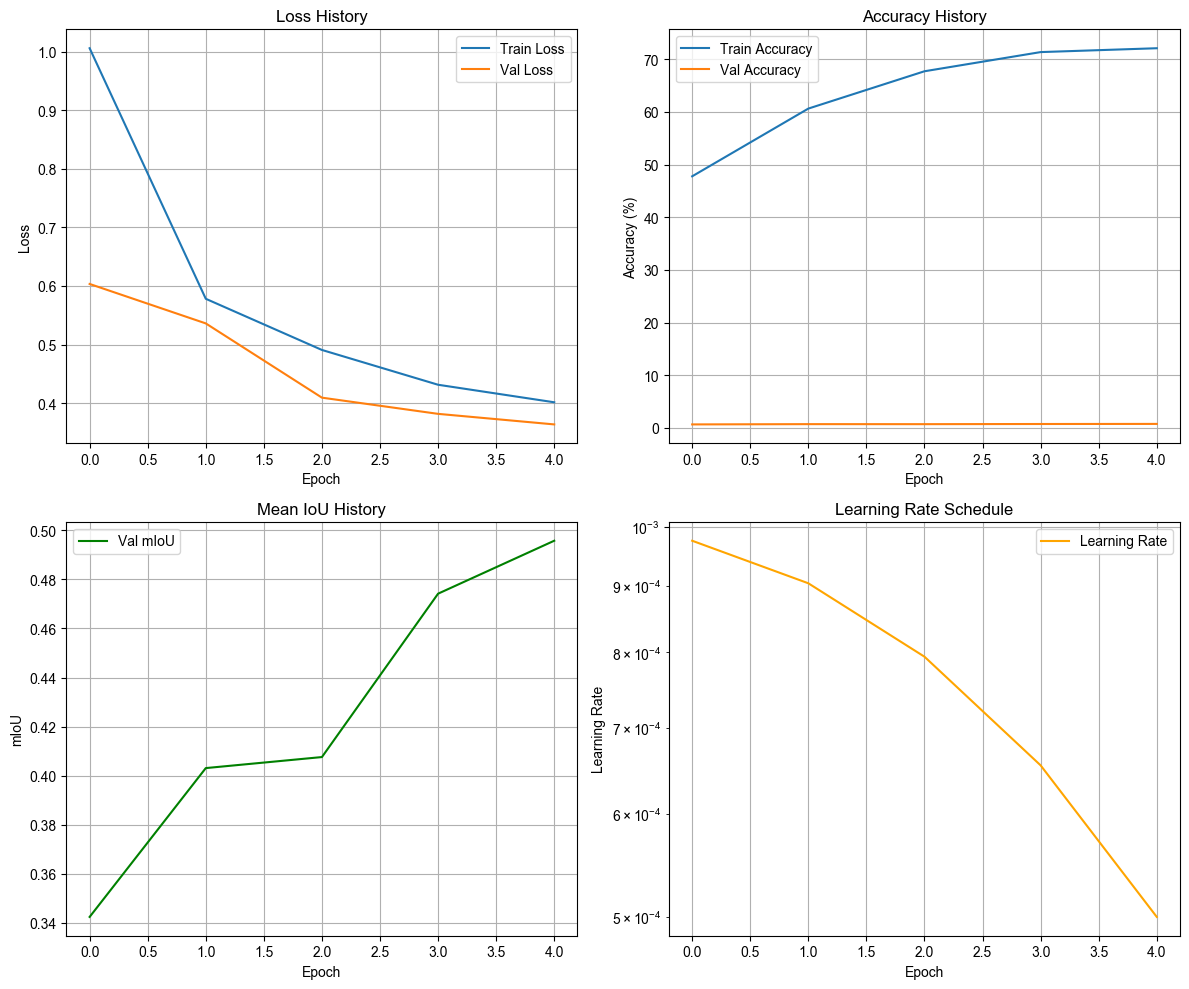

Training history plots generated and saved!


In [8]:
# 绘制训练历史
plot_training_history(history, save_path=f"{config['save_dir']}/training_curves.png")

# 保存训练历史
with open(f"{config['save_dir']}/history.json", 'w') as f:
    json.dump(history, f, indent=4)

print("Training history plots generated and saved!")

## 9. 模型评估

In [9]:
# 加载最佳模型
import torch
try:
    # 尝试使用weights_only=False（PyTorch 2.6+）
    checkpoint = torch.load(f"{config['save_dir']}/best_model.pth", map_location=device, weights_only=False)
except TypeError:
    # 如果不支持weights_only参数，使用旧版本语法
    checkpoint = torch.load(f"{config['save_dir']}/best_model.pth", map_location=device)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded best model (epoch {checkpoint['epoch']}, mIoU: {checkpoint['best_miou']:.4f})")

# 在测试集上评估
test_loss, test_acc, test_metrics = validate(
    model, test_loader, criterion, device, data_info['num_classes']
)

print(f"\nTest Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Test mIoU: {test_metrics['mean_iou']:.4f}")
print(f"Mean Class Accuracy: {test_metrics['mean_accuracy']:.4f}")

# 详细的每类指标
print(f"\nPer-class metrics:")
for i, class_name in data_info['class_names'].items():
    if i < len(test_metrics['per_class_accuracy']):
        acc = test_metrics['per_class_accuracy'][i]
        iou = test_metrics['per_class_iou'][i]
        print(f"  {class_name}: Acc={acc:.3f}, IoU={iou:.3f}")

Loaded best model (epoch 5, mIoU: 0.4958)


Validation:   0%|          | 0/60 [00:00<?, ?it/s]


Test Results:
Test Loss: 0.3760
Test Accuracy: 0.74%
Test mIoU: 0.4737
Mean Class Accuracy: 0.7369

Per-class metrics:
  Corn: Acc=0.793, IoU=0.756
  Wheat: Acc=0.946, IoU=0.395
  Sunflower: Acc=0.784, IoU=0.593
  Pumpkin: Acc=0.858, IoU=0.320
  Artificial_Surface: Acc=0.810, IoU=0.456
  Water: Acc=0.912, IoU=0.765
  Road: Acc=0.548, IoU=0.331
  Other: Acc=0.244, IoU=0.173


## 10. 评估结果可视化

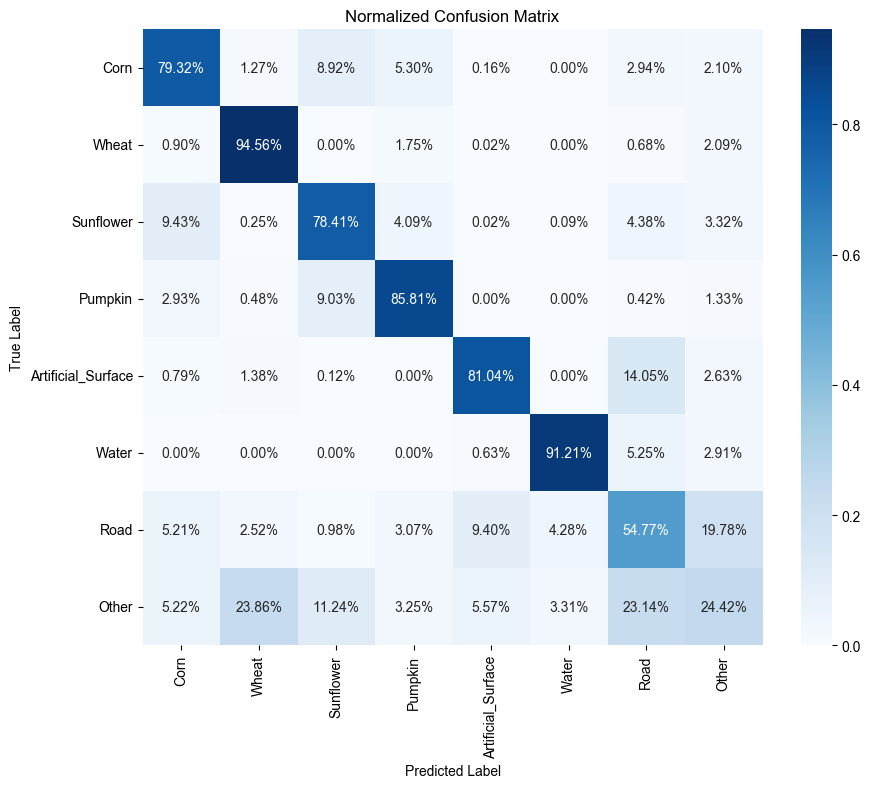

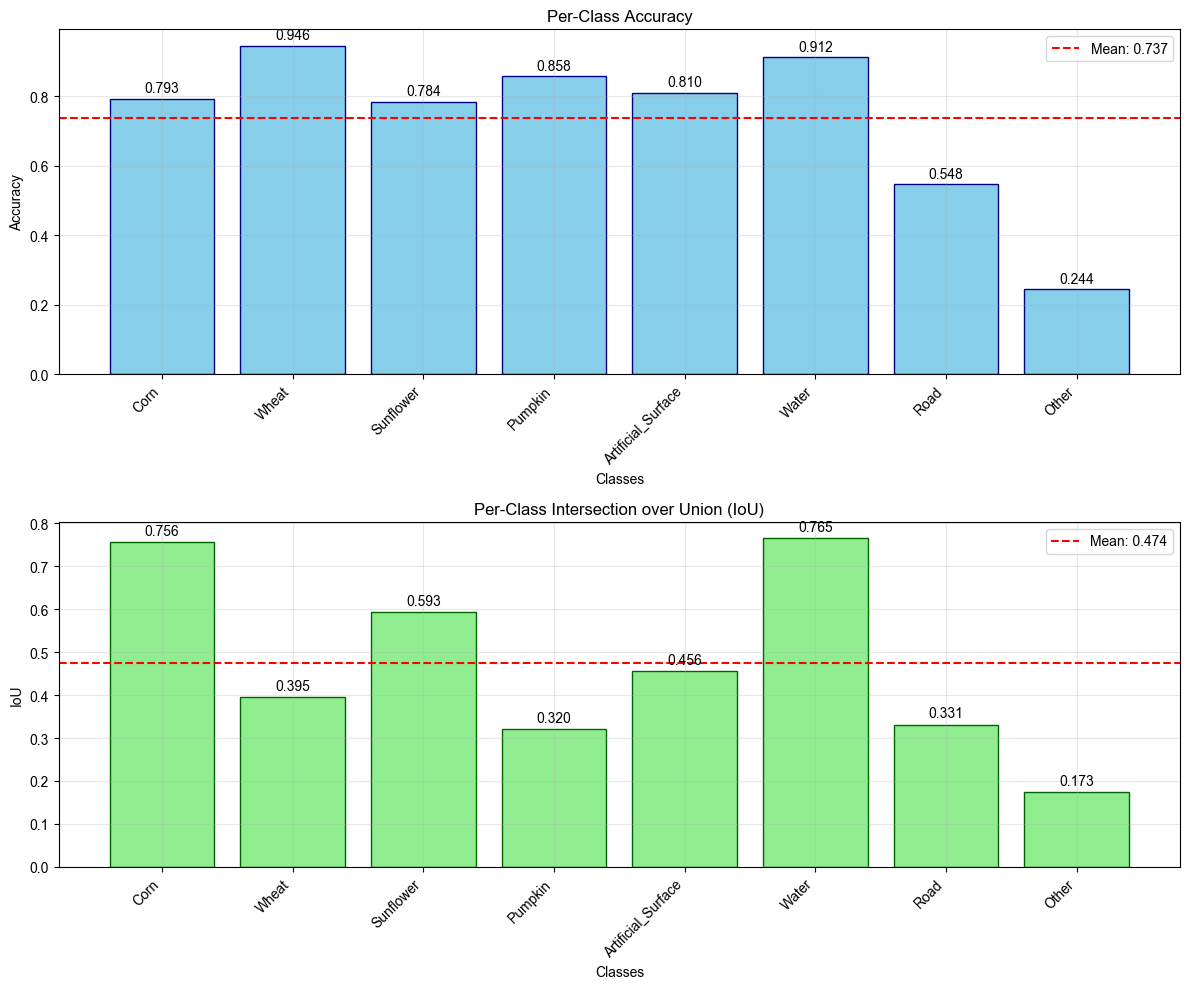

In [10]:
# 绘制混淆矩阵
class_names_list = [data_info['class_names'][i] for i in range(data_info['num_classes'])]
plot_confusion_matrix(
    test_metrics['confusion_matrix'],
    class_names_list,
    save_path=f"{config['save_dir']}/confusion_matrix.png"
)

# 绘制类别性能图 - 需要先添加class_names到metrics中
test_metrics_with_names = test_metrics.copy()
test_metrics_with_names['class_names'] = {i: name for i, name in data_info['class_names'].items()}

plot_class_performance(
    test_metrics_with_names, 
    save_path=f"{config['save_dir']}/class_performance.png"
)

## 11. 预测样本可视化

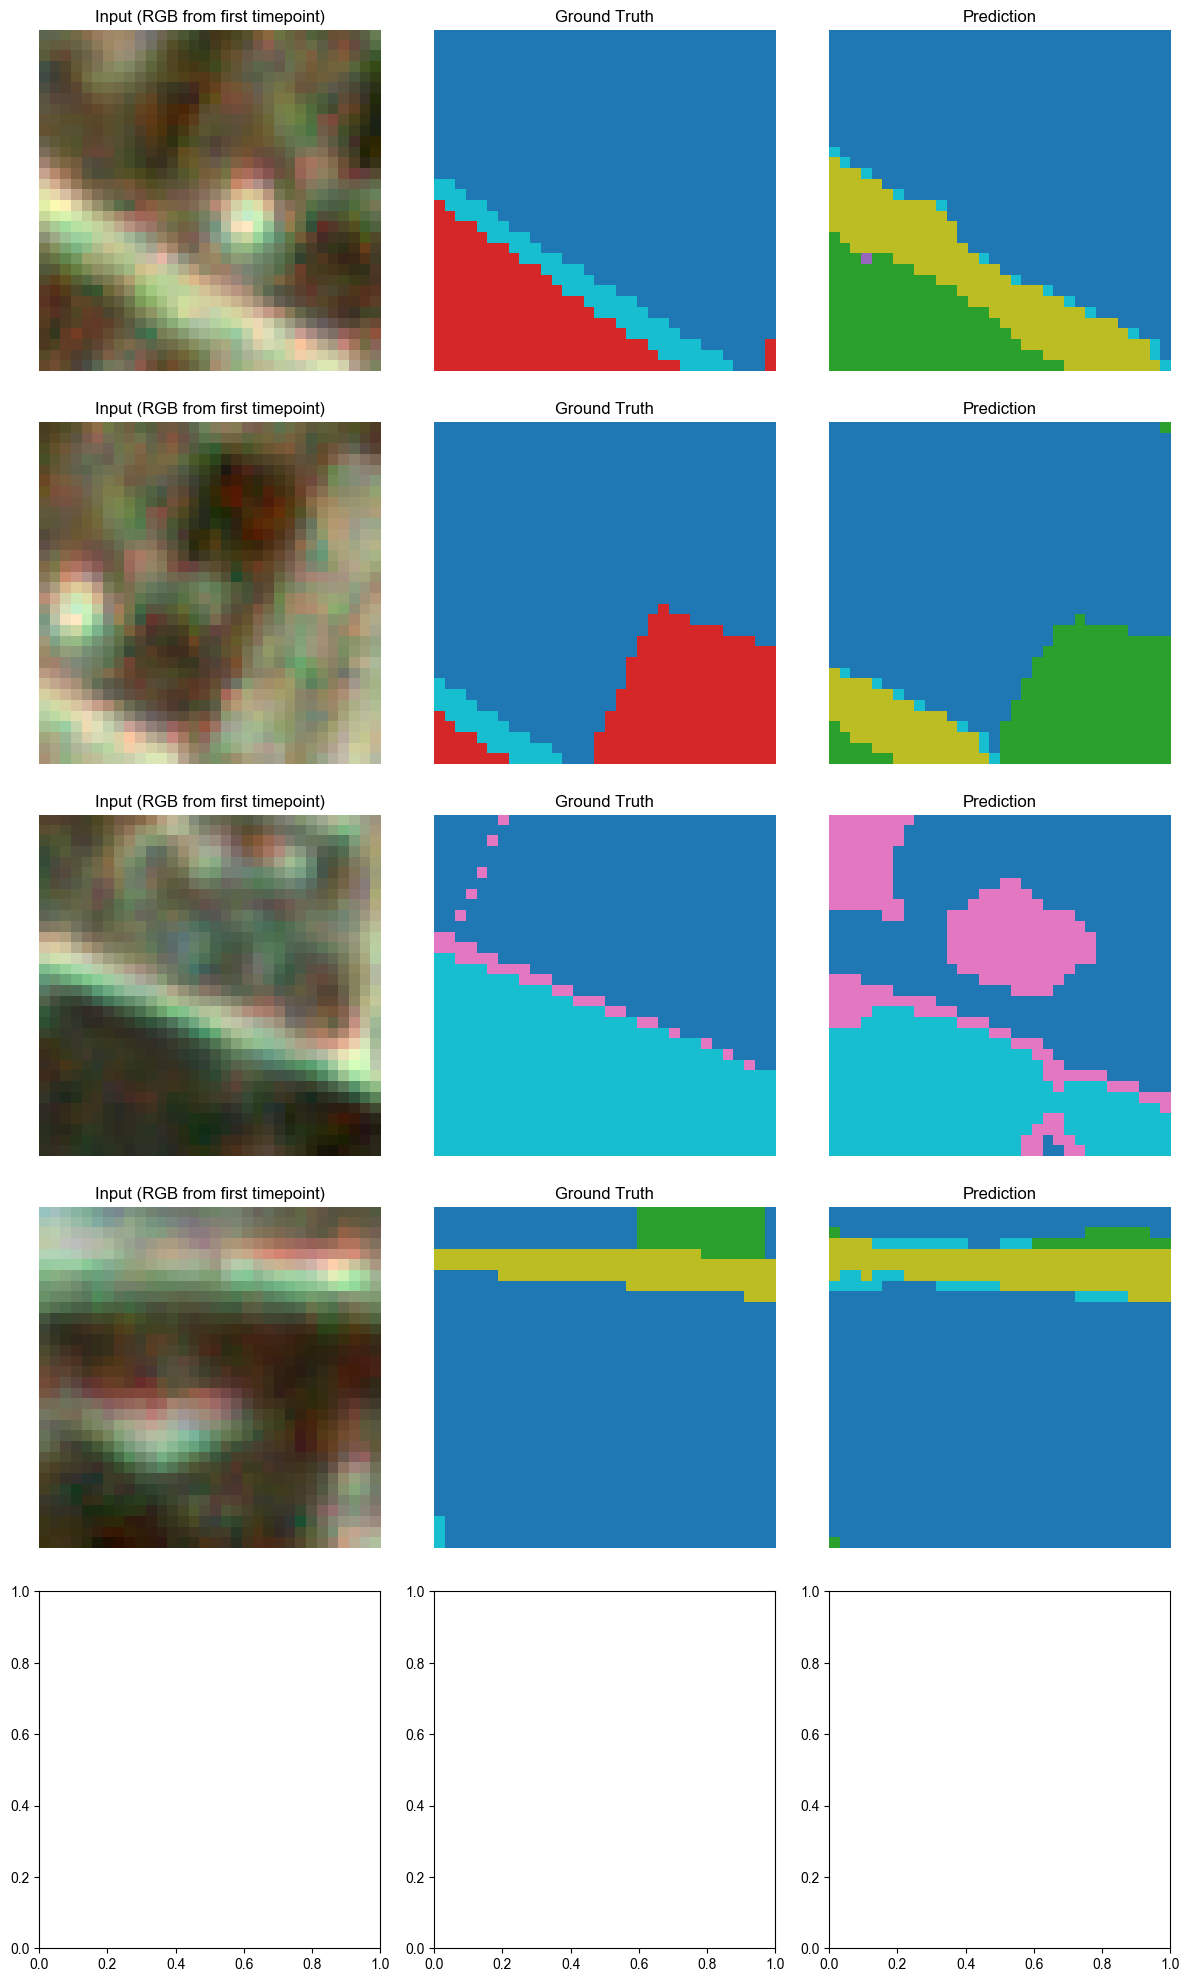

In [11]:
from TCN.utils import visualize_predictions

# 获取一批测试数据
data_iter = iter(test_loader)
test_batch_data, test_batch_targets = next(data_iter)

# 预测
model.eval()
with torch.no_grad():
    test_batch_data_device = test_batch_data.to(device)
    test_outputs = model(test_batch_data_device)
    _, test_predictions = test_outputs.max(-1)

# 可视化前5个样本的预测结果
visualize_predictions(
    test_batch_data[:5],
    test_batch_targets[:5],
    test_predictions[:5].cpu(),
    class_names_list,
    num_samples=5,
    save_path=f"{config['save_dir']}/predictions_visualization.png"
)

## 12. 模型推理示例

Model loaded successfully on cpu
Number of classes: 8
Running inference on (128, 128) region...
Predicting 25 patches...


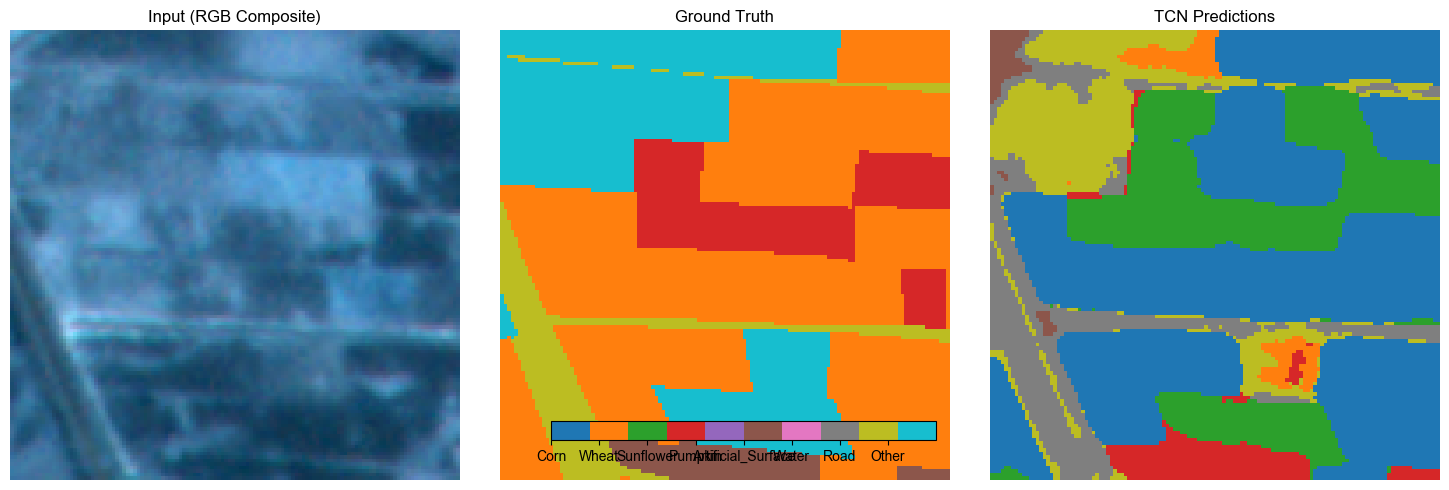


Inference accuracy on cropped region: 0.0128

Prediction distribution:
  Corn: 7,895 pixels (48.2%)
  Wheat: 366 pixels (2.2%)
  Sunflower: 3,254 pixels (19.9%)
  Pumpkin: 719 pixels (4.4%)
  Artificial_Surface: 182 pixels (1.1%)
  Road: 1,860 pixels (11.4%)
  Other: 2,108 pixels (12.9%)


In [12]:
from TCN.inference import CropMappingInference

# 初始化推理器
inferencer = CropMappingInference(
    model_path=f"{config['save_dir']}/best_model.pth",
    device=config['device']
)

# 加载完整数据集进行推理演示（使用较小的区域）
full_x_data = np.load('../dataset/x.npy')
full_y_data = np.load('../dataset/y.npy')

# 选择一个较小的区域进行快速推理演示
crop_size = 128
x_crop = full_x_data[:crop_size, :crop_size]
y_crop = full_y_data[:crop_size, :crop_size]

print(f"Running inference on {x_crop.shape[:2]} region...")

# 进行推理
predictions = inferencer.predict_full_image(
    x_crop,
    patch_size=32,  # 使用较小的patch以加快推理
    overlap=8,
    batch_size=4
)

# 可视化推理结果
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 显示RGB合成图（使用第一个时间步的前三个波段）
rgb = x_crop[:, :, 0, :3]
rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())
axes[0].imshow(rgb)
axes[0].set_title('Input (RGB Composite)')
axes[0].axis('off')

# 显示真实标签
im1 = axes[1].imshow(y_crop, cmap='tab10', vmin=0, vmax=8)
axes[1].set_title('Ground Truth')
axes[1].axis('off')

# 显示预测结果
axes[2].imshow(predictions, cmap='tab10', vmin=0, vmax=8)
axes[2].set_title('TCN Predictions')
axes[2].axis('off')

# 添加颜色条
cbar = plt.colorbar(im1, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_ticks(range(len(class_names_list)))
cbar.set_ticklabels([name.split('(')[0].strip() if '(' in name else name for name in class_names_list])

plt.tight_layout()
plt.savefig(f"{config['save_dir']}/inference_example.png", dpi=300, bbox_inches='tight')
plt.show()

# 计算推理准确率
inference_acc = np.mean(predictions == y_crop)
print(f"\nInference accuracy on cropped region: {inference_acc:.4f}")

# 统计预测分布
unique, counts = np.unique(predictions, return_counts=True)
print("\nPrediction distribution:")
for label, count in zip(unique, counts):
    percentage = count / predictions.size * 100
    class_name = data_info['class_names'].get(label, f"Unknown({label})")
    print(f"  {class_name}: {count:,} pixels ({percentage:.1f}%)")

## 13. 总结与结论

In [13]:
# 生成最终总结报告
summary_report = f"""
=== TCN模型训练总结报告 ===
训练时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
设备: {device}

模型配置:
- 输入通道数: {config['input_channels']}
- 时间步数: {config['temporal_steps']}
- TCN通道: {config['tcn_channels']}
- 类别数: {data_info['num_classes']}
- 总参数量: {total_params:,}

训练配置:
- 训练轮数: {len(history['train_loss'])}
- 批次大小: {config['batch_size']}
- 学习率: {config['learning_rate']}
- 切片大小: {config['patch_size']}

最佳性能 (验证集):
- mIoU: {best_miou:.4f}
- 准确率: {max(history['val_acc']):.2f}%

测试集性能:
- mIoU: {test_metrics['mean_iou']:.4f}
- 总体准确率: {test_metrics['overall_accuracy']:.4f}
- 平均类别准确率: {test_metrics['mean_accuracy']:.4f}

文件输出:
- 最佳模型: {config['save_dir']}/best_model.pth
- 训练历史: {config['save_dir']}/history.json
- 数据信息: {config['save_dir']}/data_info.pkl
- 训练曲线: {config['save_dir']}/training_curves.png
- 混淆矩阵: {config['save_dir']}/confusion_matrix.png

=== 报告结束 ===
"""

print(summary_report)

# 保存报告
with open(f"{config['save_dir']}/training_summary.txt", 'w', encoding='utf-8') as f:
    f.write(summary_report)

print(f"\n🎯 训练完成！所有结果已保存到: {config['save_dir']}/")
print(f"📊 最佳模型mIoU: {best_miou:.4f}")
print(f"📈 测试集mIoU: {test_metrics['mean_iou']:.4f}")


=== TCN模型训练总结报告 ===
训练时间: 2025-07-26 15:45:48
设备: mps

模型配置:
- 输入通道数: 8
- 时间步数: 28
- TCN通道: [32, 64]
- 类别数: 8
- 总参数量: 34,216

训练配置:
- 训练轮数: 5
- 批次大小: 4
- 学习率: 0.001
- 切片大小: 32

最佳性能 (验证集):
- mIoU: 0.4958
- 准确率: 0.76%

测试集性能:
- mIoU: 0.4737
- 总体准确率: 0.7353
- 平均类别准确率: 0.7369

文件输出:
- 最佳模型: ./checkpoints_test/best_model.pth
- 训练历史: ./checkpoints_test/history.json
- 数据信息: ./checkpoints_test/data_info.pkl
- 训练曲线: ./checkpoints_test/training_curves.png
- 混淆矩阵: ./checkpoints_test/confusion_matrix.png

=== 报告结束 ===


🎯 训练完成！所有结果已保存到: ./checkpoints_test/
📊 最佳模型mIoU: 0.4958
📈 测试集mIoU: 0.4737


In [14]:
import numpy as np
import sys
sys.path.append('/Users/ff_crazy/ myProj/DeepCropMapping')

# 加载数据集
y_data = np.load('/Users/ff_crazy/ myProj/DeepCropMapping/dataset/y.npy')
unique_labels, counts = np.unique(y_data, return_counts=True)

print('数据集中的标签分布：')
for label, count in zip(unique_labels, counts):
    percentage = count / y_data.size * 100
    print(f'  标签 {label}: {count:,} 像素 ({percentage:.1f}%)')

print(f'\n标签范围: {unique_labels.min()} - {unique_labels.max()}')
print(f'总类别数: {len(unique_labels)}')

数据集中的标签分布：
  标签 0: 2 像素 (0.0%)
  标签 1: 183,988 像素 (55.1%)
  标签 2: 6,526 像素 (2.0%)
  标签 3: 61,775 像素 (18.5%)
  标签 4: 9,623 像素 (2.9%)
  标签 5: 7,496 像素 (2.2%)
  标签 6: 9,332 像素 (2.8%)
  标签 7: 24,438 像素 (7.3%)
  标签 8: 30,970 像素 (9.3%)

标签范围: 0 - 8
总类别数: 9
